In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import gzip

sns.set_theme()

statDir = "D:/stats/"

def readData(file):
    dtypes={
        'nodes':float,
        'prune0': float,'prune1': float,'prune2': float,'prune3': float,'prune4': float,'prune5': float,'prune6': float,'prune7': float,'prune8': float,'prune9': float
    }

    path = statDir + file
    if (file.endswith(".gz")):
        fd = gzip.open(path, 'rb')
    else:
        fd = open(path, 'rb')

    data = pd.read_csv(fd, dtype=dtypes)

    recovered = data[data["result"] == "recovery"].sort_values("size")
    range = np.arange(0, 11264, 1024)
    recovered["bsize"] = pd.cut(recovered["size"], range, labels=range[1:])

    return recovered


Prepare data

In [17]:

recovered_old = readData("benchmark-stats-2025-04-09-amb-pruning-rascal-0-10240.txt.gz")
#recovered = stats.readData("benchmark-stats-2025-04-19-parent-amb-3-rascal-0-10240.txt.gz")
#recovered = stats.readData("benchmark-stats-2025-04-23-parent-amb-2-rascal-0-10240.txt.gz")
#recovered = stats.readData("benchmark-stats-2025-04-23-parent-amb-any-3-rascal-0-10240.txt.gz")

# Read data at different pruning levels
recovered = []
regularNodes = []
outlierNodes = []
regularDuration = []
outlierDuration = []
for pruneLevel in range(5):
    df = readData("benchmark-stats-2025-04-29-flattener-amb-filter-rascal-0-10240maxamb-" + str(pruneLevel) + ".txt.gz")
    recovered.append(df)

    nodes99 = np.percentile(df["nodes"], [99])[0]
    print(f"99 percentile nodes: {nodes99}")
    regularNodes.append(df[df["nodes"] <= nodes99])
    outlierNodes.append(df[df["nodes"] >  nodes99])

    duration99 = np.percentile(df["duration"], [99])[0]
    regularDuration.append(df[df["duration"] <= duration99])
    outlierDuration.append(df[df["duration"] >  duration99])


99 percentile nodes: 46374.0
99 percentile nodes: 87292.30999999889
99 percentile nodes: 164905.0
99 percentile nodes: 340238.0
99 percentile nodes: 643450.0


### Visualize the recovery duration per file size bucket.

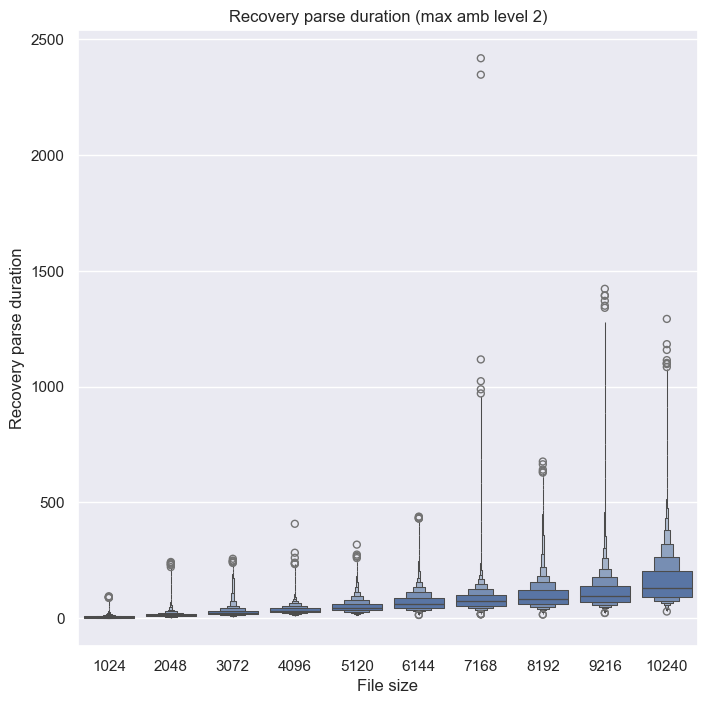

In [45]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
#ax1.set_yscale('symlog')

sns.boxenplot(
    data=recovered[2],
    x="bsize", y="duration",
    width_method="exponential",
    ax = ax1
)

#sns.violinplot(
#    data=recovered[2],
#    x="bsize", y="duration",
#    density_norm="width",
#    ax = ax1
#)

ax1.set_title("Recovery parse duration (max amb level 2)")

ax1.set_xlabel("File size")
ax1.set_ylabel("Recovery parse duration")


plt.show(fig1)

### Node distribution per file size

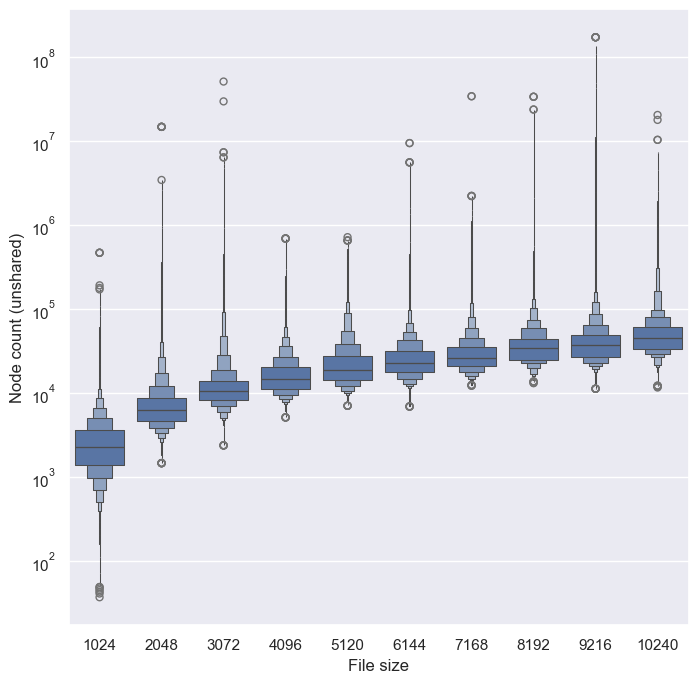

In [47]:
fig2, ax2 = plt.subplots(figsize=(8, 8), sharey=True)
ax2.set_yscale('symlog')

sns.boxenplot(
    data=recovered[2],
    x="bsize", y="nodes",
    width_method="exponential",
    ax=ax2
)

#sns.violinplot(
#    data=recovered[2],
#    x="bsize", y="nodes",
#    density_norm="width",
#    ax=ax2
#)

ax1.set_title("Parse forest node counts (max amb level 2)")
ax2.set_xlabel("File size")
ax2.set_ylabel("Node count (unshared)")

plt.show(fig2)

### Max node counts per amb pruning level

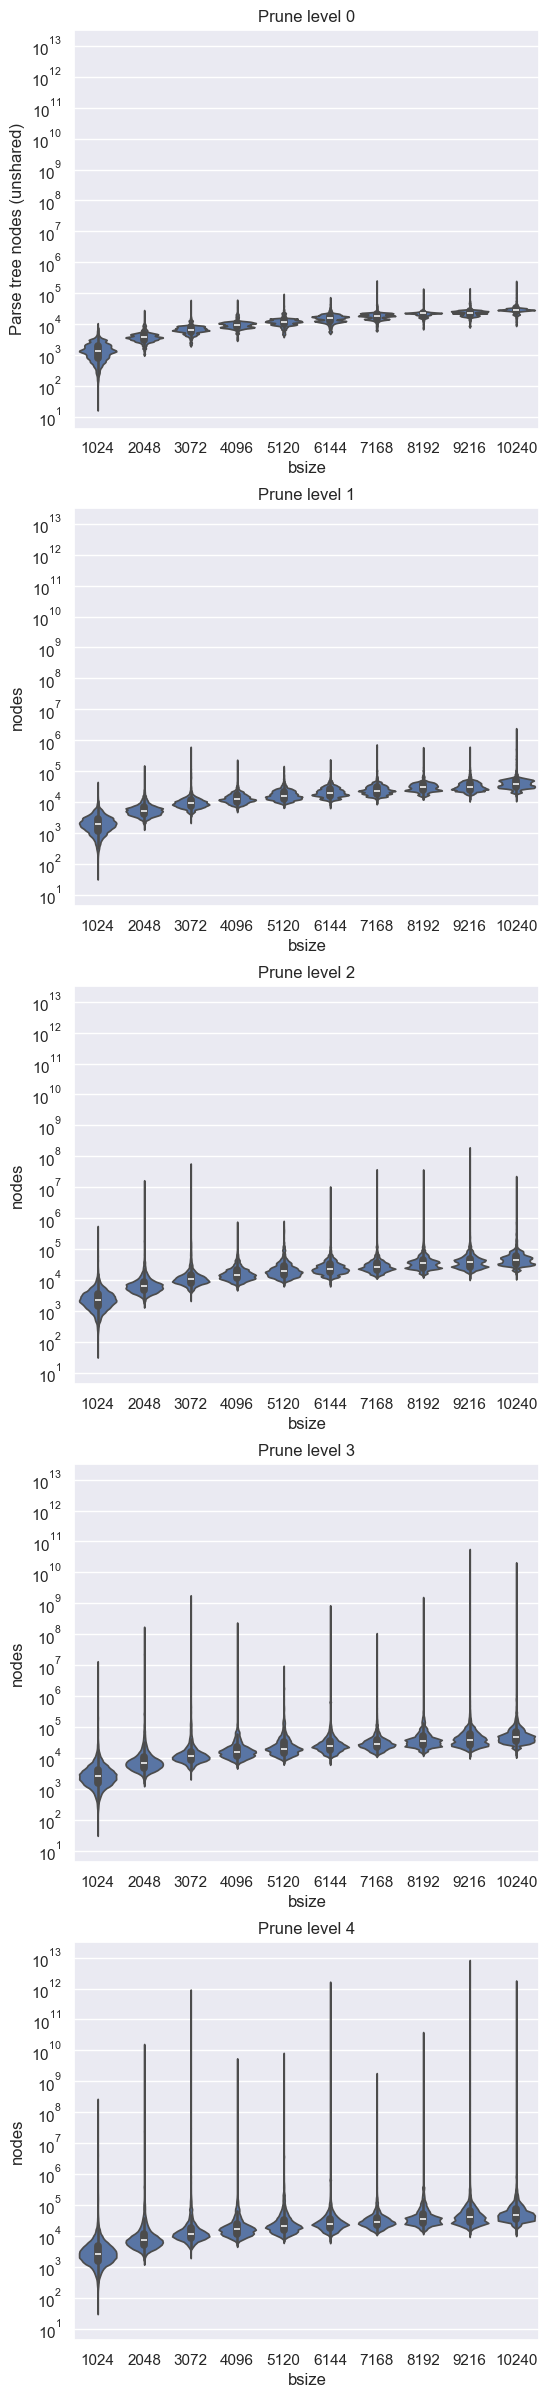

In [51]:
pruneFig, pruneAx = plt.subplots(5, 1, figsize=(6, 30), sharey=True)
pruneAx[0].set_yscale('symlog')
pruneAx[0].set_ylabel("Parse tree nodes (unshared)")

for pruneLevel in range(5):
    pruneAx[pruneLevel].set_title(f"Prune level {pruneLevel}")
    sns.violinplot(
        data=recovered[pruneLevel],
        x="bsize", y="nodes",
        density_norm="width",
        ax=pruneAx[pruneLevel]
    )

plt.show(pruneFig)


### Parse ratio vs file size

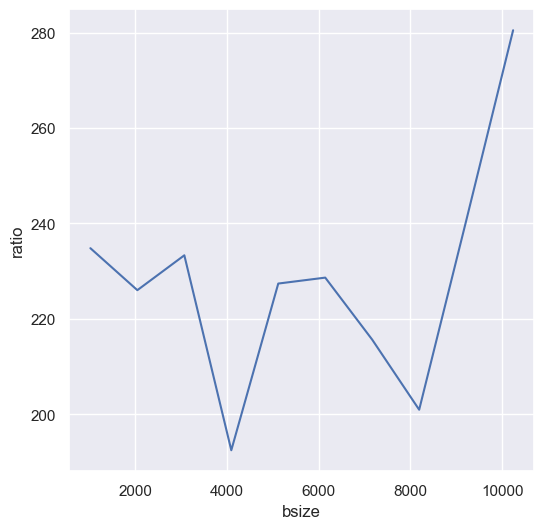

In [ ]:
ratioFig, ratioAx = plt.subplots(figsize=(6, 6))
grouped = recovered.groupby("bsize", observed=True).agg({"ratio": "mean", "nodes": "mean"}).reset_index()
sns.lineplot(data=grouped, x="bsize", y="ratio", ax=ratioAx)
plt.show(ratioFig)


